In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os

#For Preprocessing
import re    # RegEx for removing non-letter characters
from bs4 import BeautifulSoup
import nltk  #natural language processing
nltk.download('wordnet')
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
df=pd.read_csv("/content/all-data.csv",engine="python",encoding="ISO-8859-1")
df = pd.DataFrame(df)

# Set pandas display options to show full text
pd.set_option('display.max_colwidth', None)
df

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said ."
1,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported ."
2,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .
3,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales ."
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .
...,...,...
4840,negative,LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .
4841,neutral,"Rinkuskiai 's beer sales fell by 6.5 per cent to 4.16 million litres , while Kauno Alus ' beer sales jumped by 6.9 per cent to 2.48 million litres ."
4842,negative,"Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn ."
4843,negative,"Net sales of the Paper segment decreased to EUR 221.6 mn in the second quarter of 2009 from EUR 241.1 mn in the second quarter of 2008 , while operating profit excluding non-recurring items rose to EUR 8.0 mn from EUR 7.6 mn ."


In [ ]:
df = df.rename(columns=lambda col: 'sentiment' if col == 'neutral' else 'text' if col.startswith('According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .') else col)
df


,sentiment,text
0,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said ."
1,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported ."
2,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .
3,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales ."
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .
...,...,...
4840,negative,LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .
4841,neutral,"Rinkuskiai 's beer sales fell by 6.5 per cent to 4.16 million litres , while Kauno Alus ' beer sales jumped by 6.9 per cent to 2.48 million litres ."
4842,negative,"Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn ."
4843,negative,"Net sales of the Paper segment decreased to EUR 221.6 mn in the second quarter of 2009 from EUR 241.1 mn in the second quarter of 2008 , while operating profit excluding non-recurring items rose to EUR 8.0 mn from EUR 7.6 mn ."


In [ ]:
# Define a function that integrates lowercasing, special character removal, and placeholder handling
def clean_and_preprocess_text(text):
    # Clean HTML tags
    text = BeautifulSoup(text, "lxml").text

    # Replace URLs with <URL>
    text = re.sub(r'http\S+', r'<URL>', text)

    # Convert to lowercase
    text = text.lower()

    # Replace percentages (e.g., "65 per cent") with just the number and "percentage"
    text = re.sub(r'(\d+)\s*percent|\s*per cent|\s*%', r'\1 percentage', text)
    text = re.sub(r'(\d+)\s*percentageage', r'\1 percentage', text, flags=re.IGNORECASE)

    # Handle placeholders by removing angle brackets
    text = re.sub(r'<([^>]+)>', r'\1', text)  # Convert <PERCENTAGE> to PERCENTAGE

    # Remove special characters except for letters, numbers, and spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Normalize spaces: replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply the function to the 'Message' column
df['cleaned_text'] = df['text'].apply(clean_and_preprocess_text)



<ipython-input-51-d651f846587b>:4: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [ ]:
df


,sentiment,text,cleaned_text
0,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .",technopolis plans to develop in stages an area of no less than 100000 square meters in order to host companies working in computer technologies and telecommunications the statement said
1,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .",the international electronic industry company elcoteq has laid off tens of employees from its tallinn facility contrary to earlier layoffs the company contracted the ranks of its office workers the daily postimees reported
2,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .,with the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability
3,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .",according to the company s updated strategy for the years 20092012 basware targets a longterm net sales growth in the range of 20 percentage 40 percentage with an operating profit margin of 10 percentage 20 percentage of net sales
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .,financing of aspocomp s growth aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding hdi printed circuit boards pcbs
...,...,...,...
4840,negative,LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .,london marketwatch share prices ended lower in london monday as a rebound in bank stocks failed to offset broader weakness for the ftse 100
4841,neutral,"Rinkuskiai 's beer sales fell by 6.5 per cent to 4.16 million litres , while Kauno Alus ' beer sales jumped by 6.9 per cent to 2.48 million litres .",rinkuskiai s beer sales fell by 65 percentage to 416 million litres while kauno alus beer sales jumped by 69 percentage to 248 million litres
4842,negative,"Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn .",operating profit fell to eur 354 mn from eur 688 mn in 2007 including vessel sales gain of eur 123 mn
4843,negative,"Net sales of the Paper segment decreased to EUR 221.6 mn in the second quarter of 2009 from EUR 241.1 mn in the second quarter of 2008 , while operating profit excluding non-recurring items rose to EUR 8.0 mn from EUR 7.6 mn .",net sales of the paper segment decreased to eur 2216 mn in the second quarter of 2009 from eur 2411 mn in the second quarter of 2008 while operating profit excluding nonrecurring items rose to eur 80 mn from eur 76 mn


In [ ]:
df['cleaned_text'] = df['cleaned_text'].apply(nltk.word_tokenize)

stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: [word for word in x if word not in stop_words])
df


,sentiment,text,cleaned_text
0,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .","[technopolis, plans, develop, stages, area, less, 100000, square, meters, order, host, companies, working, computer, technologies, telecommunications, statement, said]"
1,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .","[international, electronic, industry, company, elcoteq, laid, tens, employees, tallinn, facility, contrary, earlier, layoffs, company, contracted, ranks, office, workers, daily, postimees, reported]"
2,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .,"[new, production, plant, company, would, increase, capacity, meet, expected, increase, demand, would, improve, use, raw, materials, therefore, increase, production, profitability]"
3,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .","[according, company, updated, strategy, years, 20092012, basware, targets, longterm, net, sales, growth, range, 20, percentage, 40, percentage, operating, profit, margin, 10, percentage, 20, percentage, net, sales]"
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .,"[financing, aspocomp, growth, aspocomp, aggressively, pursuing, growth, strategy, increasingly, focusing, technologically, demanding, hdi, printed, circuit, boards, pcbs]"
...,...,...,...
4840,negative,LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .,"[london, marketwatch, share, prices, ended, lower, london, monday, rebound, bank, stocks, failed, offset, broader, weakness, ftse, 100]"
4841,neutral,"Rinkuskiai 's beer sales fell by 6.5 per cent to 4.16 million litres , while Kauno Alus ' beer sales jumped by 6.9 per cent to 2.48 million litres .","[rinkuskiai, beer, sales, fell, 65, percentage, 416, million, litres, kauno, alus, beer, sales, jumped, 69, percentage, 248, million, litres]"
4842,negative,"Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn .","[operating, profit, fell, eur, 354, mn, eur, 688, mn, 2007, including, vessel, sales, gain, eur, 123, mn]"
4843,negative,"Net sales of the Paper segment decreased to EUR 221.6 mn in the second quarter of 2009 from EUR 241.1 mn in the second quarter of 2008 , while operating profit excluding non-recurring items rose to EUR 8.0 mn from EUR 7.6 mn .","[net, sales, paper, segment, decreased, eur, 2216, mn, second, quarter, 2009, eur, 2411, mn, second, quarter, 2008, operating, profit, excluding, nonrecurring, items, rose, eur, 80, mn, eur, 76, mn]"


In [ ]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

df['cleaned_text'] = df['cleaned_text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join(x))
df

,sentiment,text,cleaned_text
0,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .",technopolis plan develop stage area le 100000 square meter order host company working computer technology telecommunication statement said
1,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .",international electronic industry company elcoteq laid ten employee tallinn facility contrary earlier layoff company contracted rank office worker daily postimees reported
2,positive,With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .,new production plant company would increase capacity meet expected increase demand would improve use raw material therefore increase production profitability
3,positive,"According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .",according company updated strategy year 20092012 basware target longterm net sale growth range 20 percentage 40 percentage operating profit margin 10 percentage 20 percentage net sale
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is aggressively pursuing its growth strategy by increasingly focusing on technologically more demanding HDI printed circuit boards PCBs .,financing aspocomp growth aspocomp aggressively pursuing growth strategy increasingly focusing technologically demanding hdi printed circuit board pcbs
...,...,...,...
4840,negative,LONDON MarketWatch -- Share prices ended lower in London Monday as a rebound in bank stocks failed to offset broader weakness for the FTSE 100 .,london marketwatch share price ended lower london monday rebound bank stock failed offset broader weakness ftse 100
4841,neutral,"Rinkuskiai 's beer sales fell by 6.5 per cent to 4.16 million litres , while Kauno Alus ' beer sales jumped by 6.9 per cent to 2.48 million litres .",rinkuskiai beer sale fell 65 percentage 416 million litre kauno alus beer sale jumped 69 percentage 248 million litre
4842,negative,"Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007 , including vessel sales gain of EUR 12.3 mn .",operating profit fell eur 354 mn eur 688 mn 2007 including vessel sale gain eur 123 mn
4843,negative,"Net sales of the Paper segment decreased to EUR 221.6 mn in the second quarter of 2009 from EUR 241.1 mn in the second quarter of 2008 , while operating profit excluding non-recurring items rose to EUR 8.0 mn from EUR 7.6 mn .",net sale paper segment decreased eur 2216 mn second quarter 2009 eur 2411 mn second quarter 2008 operating profit excluding nonrecurring item rose eur 80 mn eur 76 mn


## **Data Visualization on Cleaning and Preprocessing**

<ipython-input-55-2d409bb73bae>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning

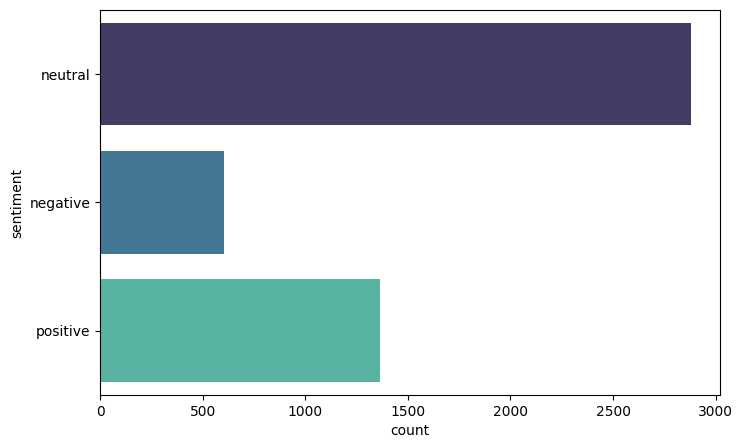

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(y="sentiment", data=df, palette="mako")


## **Applying Term Frequence - Inverse Document Frequency(TF-IDF)  - For comparision**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(max_features=100)
tfd=tfidf.fit_transform(df["cleaned_text"]).toarray()

import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000,
    formatter=dict(float=lambda x: "%.3g" % x))

In [ ]:
tfd

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.54, 0, 0, 0, 0, 0, 0.291, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.346, 0, 0, 0, 0, 0, 0, 0, 0.502, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.526, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.495, 0.498, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.124, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0.211, 0, 0, 0.435, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.462, 0],
       [0.264, 0, 0, 0, 0, 0, 0, 0.243, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.139, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0.701, 0, 0, 0, 0, 0, 0.179, 0, 0, 0, 0, 0, 0, 0, 0.344, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.194],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Step 1: Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Step 2: Fit and transform the 'sentiment' column
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])




In [ ]:
## Train Test Split
from sklearn.model_selection import train_test_split
# Assign the 'sentiment' column to the variable y
y = df['sentiment']
tfd_train,tfd_test,y_train,y_test=train_test_split(tfd,y,test_size=0.20)

In [ ]:
tfd_train[:5]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.915, 0, 0.21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.345, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## **RandomForestClassifier**

In [ ]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(tfd_train, y_train)

# Step 8: Predict and evaluate
y_pred_rf = clf.predict(tfd_test)

# Step 9: Display the results
rf_accuracy_score=accuracy_score(y_test, y_pred_rf)
print('Random Forest Classifier')
print("Accuracy:", rf_accuracy_score)
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier
Accuracy: 0.672858617131063
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.32      0.42       119
           1       0.71      0.90      0.79       580
           2       0.55      0.35      0.43       270

    accuracy                           0.67       969
   macro avg       0.62      0.52      0.54       969
weighted avg       0.65      0.67      0.64       969



# **SVM Model**

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline



# Step 2: Initialize and apply LabelEncoder on the 'sentiment' column
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])  # Encode sentiment

# Step 3: Split data into training and testing sets
tfd_train, tfd_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

# Step 4: Create a pipeline with TF-IDF and SVM classifier
pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english', max_df=0.7),
    SVC(kernel='linear')
)

# Step 5: Train the model
pipeline.fit(tfd_train, y_train)

# Step 6: Make predictions on the test set
y_pred_svm = pipeline.predict(tfd_test)

# Step 7: Evaluate the model's performance
svm_accuracy_score=accuracy_score(y_test, y_pred_svm)
print('Support Vector Machine')
print("Accuracy:", svm_accuracy_score)
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


Support Vector Machine
Accuracy: 0.7285861713106295
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.48      0.57       115
           1       0.74      0.89      0.81       567
           2       0.71      0.51      0.59       287

    accuracy                           0.73       969
   macro avg       0.71      0.63      0.65       969
weighted avg       0.72      0.73      0.71       969



In [ ]:
# Step 8: Make predictions on the train set
y_pred_train = pipeline.predict(tfd_train)

# Step 9: Evaluate the model's performance on training set
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Train Accuracy:", train_accuracy)
print("Train Classification Report:\n", classification_report(y_train, y_pred_train))

Train Accuracy: 0.9192466460268318
Train Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86       489
           1       0.91      0.98      0.94      2311
           2       0.96      0.83      0.89      1076

    accuracy                           0.92      3876
   macro avg       0.92      0.88      0.90      3876
weighted avg       0.92      0.92      0.92      3876



In [ ]:
df.columns

Index(['sentiment', 'text', 'cleaned_text'], dtype='object')

# **Navie Bayes**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


# Step 1: Vectorize text data using TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfid = tfidf.fit_transform(df['text'])  # 'text' column contains the news articles
y = df['sentiment']  # 'label' column contains the categories or sentiments # Changed 'seniment' to 'sentiment'

# Step 2: Split the data into training and testing sets
tfid_train, tfid_test, y_train, y_test = train_test_split(tfid, y, test_size=0.2, random_state=42)

# Step 3: Initialize and train the Naive Bayes model
model = MultinomialNB()
model.fit(tfid_train, y_train)

# Step 4: Make predictions
y_pred_nb = model.predict(tfid_test)

# Step 5: Evaluate the model
nb_accuracy_score=accuracy_score(y_test, y_pred_nb)
print('Naive Bayes')
print("Accuracy:", nb_accuracy_score)
print("Classification Report:\n", classification_report(y_test, y_pred_nb))

Naive Bayes
Accuracy: 0.6769865841073271
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.08      0.15       115
           1       0.69      0.95      0.80       567
           2       0.61      0.39      0.47       287

    accuracy                           0.68       969
   macro avg       0.77      0.47      0.47       969
weighted avg       0.70      0.68      0.62       969



In [ ]:
# Assuming rf_accuracy_score, svm_accuracy_score, nb_accuracy_score are defined
print("Random Forest Accuracy:", rf_accuracy_score)
print("SVM Accuracy:", svm_accuracy_score)
print("Naive Bayes Accuracy:", nb_accuracy_score)

# Create a dictionary to store model names and accuracy scores
data = {'Model': ['Random Forest', 'SVM', 'Naive Bayes'],
        'Accuracy': [rf_accuracy_score, svm_accuracy_score, nb_accuracy_score]}

# Create a pandas DataFrame
df_accuracy = pd.DataFrame(data)

# Sort the DataFrame by Accuracy in descending order
df_accuracy_sorted = df_accuracy.sort_values(by='Accuracy', ascending=False)

# Print the sorted DataFrame
df_accuracy_sorted

Random Forest Accuracy: 0.6800825593395253
SVM Accuracy: 0.7285861713106295
Naive Bayes Accuracy: 0.6769865841073271


,Model,Accuracy
1,SVM,0.728586
0,Random Forest,0.680083
2,Naive Bayes,0.676987
